In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print("Project Started")

Project Started


In [2]:
#import functions
from plots import *
from helpers import *
import time

path_dataset = "../datasets/data_train.csv"
#path_dataset = "../datasets/movielens100k.csv"

ratings = load_data(path_dataset)
ratings = ratings.toarray()
ratings = ratings.astype(np.int8)


number of items: 10000, number of users: 1000


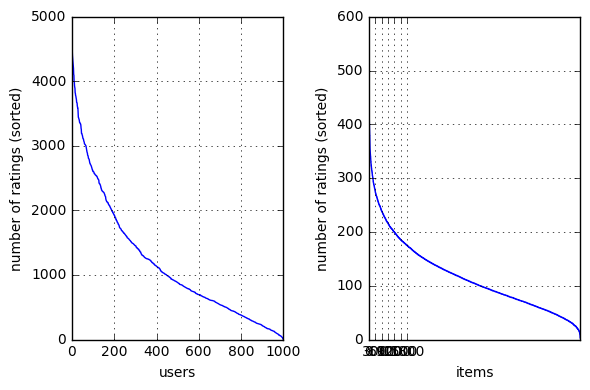

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    N = np.nonzero(valid_ratings)[0].shape[0]
    N_train = np.ceil((1-p_test)*N)
    
    flat = np.reshape(valid_ratings, (valid_ratings.shape[0]*valid_ratings.shape[1],1))
    
    indices = np.nonzero(flat)[0]  

    indices = np.random.permutation(indices)
    train_indices = indices[0:N_train-1]
    test_indices = indices[N_train:N]
    
    train = np.zeros(flat.shape, dtype =np.int8)
    test = np.zeros(flat.shape,  dtype =np.int8)
    
    train_indices = np.asarray(train_indices)
    test_indices = np.asarray(test_indices)
    print(train_indices.shape)
    for i in range(train_indices.shape[0]):
        train[train_indices[i]] = flat[train_indices[i],0]
    
    for i in range(test_indices.shape[0]):
        test[test_indices[i]] = flat[test_indices[i],0]
    
    train = np.reshape(train, valid_ratings.shape) 
    test = np.reshape(test, valid_ratings.shape)

    return valid_ratings, train, test

/home/gregoire/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gregoire/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1059256,)


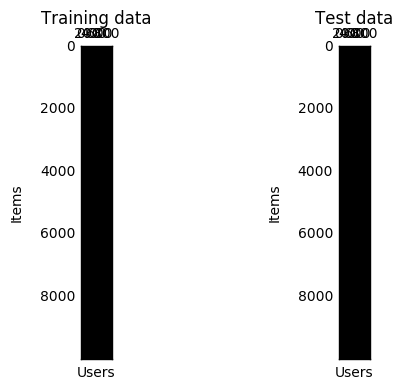

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
plot_train_test_data(train, test)

In [6]:
print(np.sum(test>0))


117695


In [7]:
#ratings = ratings.toarray()

#Max rate given by user
K = 5

def compute_user_rate_matrix(ratings_, user_id):
    
    user_rates = ratings_[:, user_id]
    
    #1 for rated movies, 0 elsewhere
    nz = np.nonzero(user_rates)[0]
    
    #number of rated movies
    m = nz.shape[0]

    #what is the index of rated movies
    movie_index = np.where(user_rates >0)[0]
    rate_matrix = np.zeros((m, K), dtype = np.bool)
    for i in range(m):
        rate_matrix[i , user_rates[movie_index[i]]-1]=1
        
    
    return m, movie_index, rate_matrix

import csv
def matrix2file(filename, prediction, evaluated_on):
    """
    Creates an output file in csv format for submission to kaggle
    """
    print("Creating csv result file")
    with open(filename, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for user in range(prediction.shape[1]):
            required_rates = np.where(evaluated_on[:, user]>0)[0]
            for i in range(required_rates.shape[0]): 
                writer.writerow({'Id': 'r'+str(required_rates[i]+1)+'_c'+str(user+1),'Prediction': prediction[required_rates[i], user]})


In [ ]:
import time
#Computes sigmoid values for matrix
#Adapted to avoid exp overflow for large t values
#Roughly when t(i) very high, sigma(t(i)) equals 1
def sigmoid(t):
    """apply sigmoid function on t."""
    toSigma = t
    sigma = np.ones(toSigma.shape)/(np.ones(toSigma.shape)+np.exp(-1*toSigma));

    
    return sigma


#v has m lines (correspondings to movies) and K columns
#b too
#h has F lines of zeros and ones
#W has nMovies lines, F columns and K in third dimension    
def compute_p_v_h(w, b_v, h, m, movies_index):
    
    h = h.reshape((h.shape[0],1))
    p = np.zeros((m, K))
    for k in range(K):
        w_sel = w[ movies_index,:,k]
        p[:,k] = np.exp(h.T@w_sel.T + b_v[movies_index,k])
    sum_ = np.sum(p, axis = 1)
    for k in range(K):
        p[:,k] = p[:,k]/sum_
 
    return p

#b has F lines
#V has m lines and K columns (return of coompute_user_rate_matrix)
def compute_p_h_v(w, b_h,  V, m, movies_index, F):
    p_h_v = np.zeros((F,1))
    for j in range(F):
        sum_ = 0
        w_p = w[movies_index, j ,:]
        sum_ = np.sum(np.einsum('ij,ji->i',V, w_p.T))            
        p_h_v[j] = sum_ +b_h[j]
    
    return sigmoid(p_h_v)
    
    

#returns a column vector of size F
def compute_first_term(w, ratings, movie_index, hu_index,  rating_index, p_h_v_all):
    
    count = 0;
    sum_ = 0;
    movie_ratings = ratings[movie_index, :]
    #line matrix
    movie_ratings = np.reshape(movie_ratings,(1, movie_ratings.shape[0]))
    #line matrix
    user_index_list = np.where(movie_ratings == rating_index+1)
    user_index_list = np.reshape(user_index_list, (1, user_index_list.shape[0]))
    #We go through all users for whom we know that movie is rated with rate
    for i in range(user_index_list.shape[0]):
        count = count + 1
        sum_ = sum_ + p_h_v_all[hu_index,i]
    esp = sum_/count
    
    return esp


def compute_first_term_user(w, rate_matrix, movie_user_index, hu_index, rate_index, p_h_v):
    return rate_matrix[movie_user_index, rate_index]*p_h_v[hu_index]

import time

CD_iterations = 3;
esp_iter = 20
def CD_estimate(w, b_h, b_v, m, movies_index, rate_matrix, p_h_v, F):
    
    esp_h_t_v = np.zeros((m, F, K))
    esp_v = np.zeros((m, K))
    esp_h = np.zeros((F,1))

    #To compute esperance, we perform things iter time
    for iter_ in range(esp_iter):
        
        #Initialisation with data training case
        
        #V = rate_matrix
        p_h_v_iter = p_h_v
        
        for cd_iter in range(CD_iterations):
            #computing h sample
            samples = np.random.ranf(p_h_v.shape)

            h = np.greater(p_h_v_iter, samples)
            #computing new V sample
            V = np.zeros(rate_matrix.shape)

  
            p_v_h_iter = compute_p_v_h(w, b_v, h, m, movies_index)
                    
            samples = np.random.ranf((m,1))
            V = np.zeros(rate_matrix.shape)
            
            acc = np.zeros(samples.shape)
            old_acc = np.zeros(samples.shape)

            for k in range(K):
                acc = acc + np.reshape(p_v_h_iter[:,k], acc.shape)
                V[:,k]= np.reshape(np.greater(acc, samples)*np.greater(samples, old_acc), V[:,k].shape)
                old_acc = acc

            
            p_h_v_iter = compute_p_h_v(w, b_h,  V, m, movies_index, F)

        
        esp_h = esp_h + h
        esp_v = esp_v + V  

        add_ = np.zeros(esp_h_t_v.shape)
        t = time.time()
        for j in range(F):
            for k in range(K):
                add_[:,j,k] = h[j]*V[:,k]              
        esp_h_t_v = esp_h_t_v+add_
    return esp_h_t_v/esp_iter, esp_v/esp_iter, esp_h/esp_iter


def update(step, w, b_h, b_v, m, movie_index, rate_matrix, F):
    p_h_v = compute_p_h_v(w, b_h, rate_matrix, m , movie_index, F)
    cd_estimate_hv, cd_estimate_v, cd_estimate_h = CD_estimate(w, b_h, b_v, m, movie_index, rate_matrix, p_h_v, F)
    t = time.time()

    u_f_t = np.zeros((rate_matrix.shape[0], F, K))
    
    for k in range(K):
        u_f_t[:,:,k] = (p_h_v*rate_matrix[:,k]).T
                
    grad_w = np.zeros(w.shape)
    grad_h = np.zeros(b_h.shape)
    grad_v = np.zeros(b_v.shape)
    grad_w[movie_index, :,:] = u_f_t - cd_estimate_hv
    grad_v[movie_index, :] = (rate_matrix - cd_estimate_v)
    grad_h = (p_h_v-cd_estimate_h)
    return grad_w, grad_h, grad_v

def compute_p_v_p(w, b_v, p_h_v, movie_index):
    p_h_v = np.reshape(p_h_v, (p_h_v.shape[0],1))
    sum_=0
    p = np.zeros((K,1))
    for k in range(K):
        w_j = w[movie_index, :, k]
        w_j = np.reshape(w_j, (w_j.shape[0],1))
        p[k] = np.exp(p_h_v.T@w_j + b_v[movie_index, k])
        sum_ = sum_+p[k]
    return p/sum_

def compute_rate_esp(p_v_p):
    sum_ = 0
    for k in range(K):
        sum_ = sum_ + (k+1)*p_v_p[k]
    """max_ = 0
    for k in range(K):
        if p_v_p[k]>max_:
            max_ = p_v_p[k] 
            rate = k"""
    return sum_
    
def predict(w, b_h, b_v, ratings_, user_id, required_rates, F):
    new_ratings = np.copy(ratings_)
    new_ratings = new_ratings.astype(np.float)
    m, movie_index, V = compute_user_rate_matrix(new_ratings, user_id)
    missing_movie_index = np.where(new_ratings[:, user_id] ==0)[0]
    p_h_v = compute_p_h_v(w, b_h, V, m, movie_index, F)
    for i in range(required_rates.shape[0]):
        p_v_p = compute_p_v_p(w, b_v, p_h_v, required_rates[i])
        rate = compute_rate_esp(p_v_p)
        new_ratings[required_rates[i], user_id] = rate
    return new_ratings


def calculate_mse_from_matrix(M, prediction):
    """
        calculate the MSE using the original matrix and the prediction matrix
    """
    ones = M>0
    rmse = 0
    N = np.sum(ones)
    rmse = np.sum(np.square((M-prediction)*ones))
    return np.sqrt(rmse/N)

def calculate_user_mse_from_matrix(M, prediction):
    """
        calculate the MSE using the original matrix and the prediction matrix
    """
    ones = M>0
    rmse = 0
    indices = np.where(M>0)[0]
    N = np.sum(ones)
    for indic in indices:
        rmse = rmse + (M[indic]-prediction[indic])**2
    return rmse/N

def compute_score(w, b_h, b_v, ratings_test, ratings_train, F):
    nnz  = ratings_test>0
    new_ratings = np.copy(ratings_train)
    new_ratings = new_ratings.astype(np.float)
    for user_id in range(ratings_train.shape[1]):
        if(np.mod(user_id, 200)==0):
            print("Processing user n° {}".format(int(user_id)))
        required_rates = np.where(ratings_test[:, user_id]>0)[0]
        new_ratings = predict(w, b_h, b_v, new_ratings, user_id, required_rates, F)
    return new_ratings, calculate_mse_from_matrix(ratings_test,new_ratings)
    

def compute_user_score(w, b_h, b_v, ratings_train, user_id):
    required_rates = np.where(ratings_train[:, user_id]>0)[0]
    new_ratings =np.copy(ratings_train)
    new_ratings = predict(w, b_h, b_v, new_ratings, user_id, required_rates, F)
    
    return calculate_user_mse_from_matrix(ratings_train[:, user_id],new_ratings[:, user_id])

def main(rtrain_, rtest):
    nnz  = rtest>0
    max_iter = 5
    cross_validation_test = np.zeros((25,max_iter))
    cross_validation_train = np.zeros((25,max_iter))
    
    for f in  range(10):
        F = 10+(10*f)
        w = np.asarray(
                    np.random.uniform(
                        low=-4 * np.sqrt(6. / (F + rtrain_.shape[0])),
                        high=4 * np.sqrt(6. / (F + rtrain_.shape[0])),
                        size=(rtrain_.shape[0], F, K)
                    ))

        b_h = np.asarray(
                    np.random.uniform(
                        low=-4 * np.sqrt(6. / (F + rtrain_.shape[0])),
                        high=4 * np.sqrt(6. / (F + rtrain_.shape[0])),
                        size=(F,1)
                    ))

        b_v = np.asarray(
                    np.random.uniform(
                        low=-4 * np.sqrt(6. / (F + rtrain_.shape[0])),
                        high=4 * np.sqrt(6. / (F + rtrain_.shape[0])),
                        size=(rtrain_.shape[0],K)
                    ))

        """w = np.load('W.npy')
        b_v = np.load('b_v.npy')
        b_h = np.load('b_h.npy')"""
        
        step = 0.5
    
        n_users = rtrain_.shape[1]
        grad_ = np.zeros(w.shape)
        n_movies = np.sum(ratings>0, axis=0)
        
        goods = n_movies>200
        ids = np.where(goods>0)[0]
        interesting_users = sum(goods)
        

        
        
        iter_=0
        while iter_<max_iter:
            
            rtrain = np.copy(rtrain_)
            noise = np.random.ranf(rtrain.shape)
            noise = noise*(rtrain>0)
            rtrain = np.maximum(np.minimum(rtrain + (noise>0.9)*(noise<0.95)-(noise>0.95),5*(rtrain>0)),(rtrain>0))
            print(np.max((rtrain==0) * (rtrain_>0)))

            """if iter_ == 2:
                step = 0.2
            if iter_ == 3:
                step = 0.1
            if iter == 4:
                step = 0.1"""
           
            ids = np.random.permutation(ids)

            for i in range(ids.shape[0]):

                #select random user to train it's RBM
                user_id = ids[i]
                
                #w dropout
                drop_w = np.copy(w)
                drop_bh = np.copy(b_h)
                kept_hidden = np.random.ranf((1,F))<1
                drop_w[:, np.where(kept_hidden==0)[1], :] = 0
                drop_bh[np.where(kept_hidden==0)[1], 0] = 0
                
                m, movie_index, rate_matrix = compute_user_rate_matrix(rtrain, user_id)
                delta_w_, delta_h_, delta_bv = update(step, drop_w, drop_bh, b_v, m, movie_index, rate_matrix, F)
                delta_w_ = delta_w_*(drop_w!=0)
                delta_bh = delta_h_*(drop_bh!=0)
                delta_bv = delta_bv
                if np.mod(i,100)==0:
                    np.save('W.npy', w)
                    np.save('b_h.npy', b_h)
                    np.save('b_v.npy', b_v)
                    print('W saved')
                    #new step size selection
                if np.mod(i,1000)==0:
                    print("Updating step")
                    id_step = np.random.permutation(ids)[0:100]
                    rtrain_step = rtrain[:, id_step]
                    rtest_step = rtest[:, id_step]
                    selected =  np.random.ranf(rtrain_step.shape)
                    rtest_step = rtrain_step * (selected<0.1)
                    print(np.sum(rtest_step>0))
                    min_rmse = 1000
                    nstep = step
                    for l in np.logspace(-4, 0, 10):
                        test_w =  w + l * delta_w_
                        testb_h = b_h + l * delta_bh
                        testb_v = b_v + l * delta_bv
                        _, rmse = compute_score(test_w,testb_h, testb_v, rtest_step, rtrain_step,F)
                        if rmse < min_rmse and i<=step*2:
                            min_rmse = rmse
                            print(min_rmse)
                            nstep = l
                    step = nstep
                    
                            
                    print("New step : {}".format(step))

                    
                    
                w = w + step * delta_w_
                b_h = b_h + step * delta_bh
                b_v = b_v + step * delta_bv


            prediction, test_error = compute_score(1*1*w,1*b_h, 1*b_v, rtest, rtrain_,F)
            selected = np.random.ranf(rtrain.shape)
            rtrain_cv = rtrain * (selected<0.5)
            prediction, train_error = compute_score(1*1*w,1*b_h, 1*b_v, rtrain_cv, rtrain_,F)
            cross_validation_train[f,iter_] =  test_error
            cross_validation_test[f,iter_] =  train_error
            print("F : {}, Epoch : {}, Test_error : {}, Train error : {} ".format(F, iter_,test_error, train_error))
            iter_ = 1+iter_
            if step <0.005:
                break
                
            
        #prediction_evaluated, error = compute_score(w, b_h, b_v, evaluated_on, train, F)
        #matrix2file('../datasets/results.csv', prediction_evaluated, evaluated_on)
        np.save('cv_train.npy', cross_validation_train);
        np.save('cv_test.npy', cross_validation_test);

    return w, b_h, b_v

In [ ]:
w, b_h, b_v = main(train, test)
path_evaluation = "../datasets/sampleSubmission.csv"
evaluated_on = load_data(path_evaluation)
evaluated_on = evaluated_on.toarray()
evaluated_on = evaluated_on.astype(np.int8)
print("Dataset loaded with success !")

False
W saved
Updating step
11630
Processing user n° 0


/home/gregoire/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1.42622425956
Processing user n° 0
1.42616055944
Processing user n° 0
1.42602158477
Processing user n° 0
1.42571399228
Processing user n° 0
1.42501364937
Processing user n° 0
1.42335699286
Processing user n° 0
1.4197555369
Processing user n° 0
1.41640082077
Processing user n° 0
Processing user n° 0
New step : 0.21544346900318823
W saved
W saved
W saved
W saved
W saved
W saved
W saved
W saved
W saved
Processing user n° 0
Processing user n° 200
Processing user n° 400
Processing user n° 600
Processing user n° 800
Processing user n° 0
Processing user n° 200
Processing user n° 400
Processing user n° 600
Processing user n° 800
F : 10, Epoch : 0, Test_error : 1.0352461529556845, Train error : 1.0311631494419708 
False
W saved
Updating step
11439
Processing user n° 0
1.06495399635
Processing user n° 0
1.06495373268
Processing user n° 0
1.06495324471
Processing user n° 0
1.06495256719
Processing user n° 0
Processing user n° 0
Processing user n° 0
Processing user n° 0
Processing user n° 0
Proces

In [10]:
import csv
def matrix2file(filename, prediction, evaluated_on):
    """
    Creates an output file in csv format for submission to kaggle
    """
    print("Creating csv result file")
    with open(filename, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for user in range(prediction.shape[1]):
            required_rates = np.where(evaluated_on[:, user]>0)[0]
            for i in range(required_rates.shape[0]): 
                writer.writerow({'Id': 'r'+str(required_rates[i]+1)+'_c'+str(user+1),'Prediction': prediction[required_rates[i], user]})


In [11]:
mm = evaluated_on >0
tt = ratings > 0 
print(np.sum(tt))

NameError: name 'evaluated_on' is not defined

In [ ]:
prediction_evaluated, error = compute_score(w, b_h, b_v, evaluated_on, train)
matrix2file('../datasets/results.csv', prediction_evaluated, evaluated_on)

In [ ]:
#evaluated_on = evaluated_on.toarray()
print(np.where(evaluated_on[:,0]>0))